In [14]:
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [15]:
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021())

# Data preparation

In [16]:
# Read .csv data.
data = pd.read_csv("../data/processed/parlspeech_bundestag_clean.csv", parse_dates=['date'], low_memory=False)
data = data.drop(columns=['Unnamed: 0', 'index'])
data.head()

,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country
0,1991-03-12,NaN,2,Theodor Waigel,CDU/CSU,211.0,False,880,Frau Präsidentin ! Meine sehr geehrten Damen u...,DE-Bundestag,DEU
1,1991-03-12,NaN,4,Theodor Waigel,CDU/CSU,211.0,False,5756,Nicht viel besser sieht es im Strassenwesen au...,DE-Bundestag,DEU
2,1991-03-12,NaN,6,Barbara Höll,PDS/LINKE,86.0,False,233,Geehrte Frau Präsidentin ! Meine Damen und Her...,DE-Bundestag,DEU
3,1991-03-12,NaN,8,Jürgen Rüttgers,CDU/CSU,211.0,False,242,Frau Präsidentin ! Meine sehr verehrten Damen ...,DE-Bundestag,DEU
4,1991-03-12,NaN,10,Peter Struck,SPD,383.0,False,31,Frau Präsidentin ! Meine Damen und Herren ! Wi...,DE-Bundestag,DEU


In [17]:
data["party"].value_counts()

CDU/CSU      65785
SPD          56011
GRUENE       29396
FDP          25874
PDS/LINKE    21610
AfD           1492
Name: party, dtype: int64

In [18]:
from src.data.transformers.extract_features import Tokenizer, StopWordRemover
from sklearn.pipeline import Pipeline

regenerate = False
if regenerate:
    text_processing_pipeline = Pipeline([
        ('tokenizer', Tokenizer()),
        ('stop_word_remover', StopWordRemover())
    ], verbose=True)

    data = text_processing_pipeline.fit_transform(data)
    data.to_csv("../data/processed/parlspeech_bundestag_tokenized.csv", index=False)
else:
    data = pd.read_csv("../data/processed/parlspeech_bundestag_tokenized.csv", low_memory=False)

In [19]:
data.head()

,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country
0,1991-03-12,NaN,2,Theodor Waigel,CDU/CSU,211.0,False,880,frau präsidentin geehrten heute ersten beratun...,DE-Bundestag,DEU
1,1991-03-12,NaN,4,Theodor Waigel,CDU/CSU,211.0,False,5756,besser sieht strassenwesen früher vorbildliche...,DE-Bundestag,DEU
2,1991-03-12,NaN,6,Barbara Höll,PDS/LINKE,86.0,False,233,geehrte frau präsidentin verschiebung haushalt...,DE-Bundestag,DEU
3,1991-03-12,NaN,8,Jürgen Rüttgers,CDU/CSU,211.0,False,242,frau präsidentin verehrten cdu/ csu-fraktion a...,DE-Bundestag,DEU
4,1991-03-12,NaN,10,Peter Struck,SPD,383.0,False,31,frau präsidentin lehnen antrag ab allein desha...,DE-Bundestag,DEU


In [20]:
data.iloc[0].text[:300]

'frau präsidentin geehrten heute ersten beratung vorliegende entwurf bundeshaushalts 1991 haushalt wiedervereinigung fast viertel ausgaben 400 milliarden dm bezieht 3 oktober 1990 neu hinzugekommenen bundesländer umfang struktur haushaltsentwurfs zeugnis gewaltigen herausforderungen seit fall mauer s'

Let's load the hand-engineered features so we can combine them with BoW / LDA:

In [162]:
feats = pd.read_csv("../data/processed/parlspeech_bundestag_feats.csv")
feats.head()

,party,text_length,avg_sentence_length,relative_num_exclamations,relative_num_questions,readability,num_profanities,TTR,sentiment,avg_word_length,stop_word_fraction,avg_tfidf
0,CDU/CSU,5070,123.658537,0.000592,0.000394,25.45,1,0.577912,-0.082449,6.417549,0.479576,0.000023
1,CDU/CSU,36626,133.185455,0.000055,0.000055,25.65,0,0.350135,0.004907,6.389919,0.477817,0.000046
2,PDS/LINKE,1589,176.555556,0.001259,0.000000,10.90,0,0.741294,0.037170,6.666667,0.457711,0.000014
3,CDU/CSU,1394,107.230769,0.001435,0.000000,51.65,0,0.631068,-0.199800,5.451456,0.567961,0.000012
4,SPD,196,65.333333,0.010204,0.000000,27.10,0,0.960000,-0.004800,6.480000,0.480000,0.000005


Finally, let's prepare a train/test split.

In [22]:
from sklearn.model_selection import train_test_split

X = feats
X['text'] = data['text']
X = X.dropna(axis=0)
y = X['party']
X = X.drop(columns=['party'])
X.reset_index(drop=True, inplace=True)
    
# use stratified sampling here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print(y_train.value_counts() / len(y_train))
print(y_test.value_counts() / len(y_test))

CDU/CSU      0.328601
SPD          0.279838
GRUENE       0.146865
FDP          0.129246
PDS/LINKE    0.108001
AfD          0.007449
Name: party, dtype: float64
CDU/CSU      0.328618
SPD          0.279830
GRUENE       0.146863
FDP          0.129218
PDS/LINKE    0.108023
AfD          0.007448
Name: party, dtype: float64


# Bag-of-words
First, let's try if we can get the regression to work with plain old bag-of-words.

We use a StandardScaler here instead of a MinMaxScaler because that's the type of scaling logistic regression assumes - and it also yields better performance.
We experimented with different solvers, and LBFGS worked best at reasonable convergence times. It does produce warnings that it hasn't reached full convergence, but we find that letting it run for a longer time only produces very marginally better results. In our opinion, it is not worth the computational cost.

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
import scipy.sparse as ssp

class BoWExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, num_words, max_df=0.5):
        self.num_words = num_words
        self.max_df = max_df
        
    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(analyzer="word", stop_words=None, tokenizer=None, preprocessor=None, max_features=self.num_words, max_df=self.max_df) # max_df and min_df might be worth checking out later
        self.vectorizer.fit(X["text"])
        return self

    def transform(self, X):
        bow = self.vectorizer.transform(X["text"])
        #bow_df = pd.DataFrame.sparse.from_spmatrix(bow, columns=[f"bow_{x}" for x in self.vectorizer.get_feature_names_out()])
        #bow_df.reset_index(drop=True, inplace=True)
        X = X.drop(columns=["text"])
        X = X.to_numpy()
        
        #combined_df = pd.concat([X.reset_index(), bow_df.reset_index()], axis=1, ignore_index=True)
        #print(combined_df.shape)
        #print(combined_df.head())
        #return combined_df.to_numpy()
        return ssp.hstack((X, bow))

bow_regression = Pipeline([
    ('bow_extractor', BoWExtractor(num_words=1000)),
    ('scaler', StandardScaler(with_mean=False)),
    ('regression', LogisticRegression(solver='saga', random_state=42, n_jobs=-1)),
])

bow_regression_sgd = Pipeline([
    ('bow_extractor', BoWExtractor(num_words=1000)),
    ('scaler', StandardScaler()),
    ('regression', SGDClassifier(loss="log", random_state=42, n_jobs=-1)),
])

Let's do a grid search with cross-validation to find a good vocabulary size for our bag-of-words.

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'bow_extractor__num_words': [500, 1000, 2000, 3000]}
]

grid_search = GridSearchCV(bow_regression, param_grid, cv=3, scoring='accuracy', verbose=4, error_score="raise")
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END ......bow_extractor__num_words=500;, score=0.455 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END ......bow_extractor__num_words=500;, score=0.451 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ......bow_extractor__num_words=500;, score=0.454 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END .....bow_extractor__num_words=1000;, score=0.478 total time= 1.2min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END .....bow_extractor__num_words=1000;, score=0.478 total time= 1.2min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END .....bow_extractor__num_words=1000;, score=0.480 total time= 1.3min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END .....bow_extractor__num_words=2000;, score=0.497 total time= 1.4min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END .....bow_extractor__num_words=2000;, score=0.494 total time= 1.4min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END .....bow_extractor__num_words=2000;, score=0.495 total time= 1.4min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END .....bow_extractor__num_words=3000;, score=0.508 total time= 1.4min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END .....bow_extractor__num_words=3000;, score=0.504 total time= 1.4min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END .....bow_extractor__num_words=3000;, score=0.506 total time= 1.4min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('bow_extractor',
                                        BoWExtractor(num_words=1000)),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('regression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid=[{'bow_extractor__num_words': [500, 1000, 2000, 3000]}],
             scoring='accuracy', verbose=4)

Looks like using more words yields better performance. Let's evaluate BoW with 3000 words on the test set:

In [25]:
grid_search.best_estimator_

Pipeline(steps=[('bow_extractor', BoWExtractor(num_words=3000)),
                ('scaler', StandardScaler(with_mean=False)),
                ('regression',
                 LogisticRegression(n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [26]:
y_test_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.5109722569357661

Not bad, but let's see if we can do better with a larger vocabulary.

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid_with_reg = [
    {'bow_extractor__num_words': [500, 4000], 'regression__C': [0.1, 1, 5]}
]

grid_search_with_reg = GridSearchCV(bow_regression, param_grid_with_reg, cv=3, scoring='accuracy', verbose=4, error_score="raise")
grid_search_with_reg.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END bow_extractor__num_words=500, regression__C=0.1;, score=0.455 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END bow_extractor__num_words=500, regression__C=0.1;, score=0.451 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END bow_extractor__num_words=500, regression__C=0.1;, score=0.454 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END bow_extractor__num_words=500, regression__C=1;, score=0.455 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END bow_extractor__num_words=500, regression__C=1;, score=0.451 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END bow_extractor__num_words=500, regression__C=1;, score=0.454 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END bow_extractor__num_words=500, regression__C=5;, score=0.456 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END bow_extractor__num_words=500, regression__C=5;, score=0.451 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END bow_extractor__num_words=500, regression__C=5;, score=0.454 total time= 1.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END bow_extractor__num_words=4000, regression__C=0.1;, score=0.513 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END bow_extractor__num_words=4000, regression__C=0.1;, score=0.509 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END bow_extractor__num_words=4000, regression__C=0.1;, score=0.513 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END bow_extractor__num_words=4000, regression__C=1;, score=0.513 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END bow_extractor__num_words=4000, regression__C=1;, score=0.509 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END bow_extractor__num_words=4000, regression__C=1;, score=0.513 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END bow_extractor__num_words=4000, regression__C=5;, score=0.513 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END bow_extractor__num_words=4000, regression__C=5;, score=0.509 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END bow_extractor__num_words=4000, regression__C=5;, score=0.513 total time= 1.5min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('bow_extractor',
                                        BoWExtractor(num_words=1000)),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('regression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid=[{'bow_extractor__num_words': [500, 4000],
                          'regression__C': [0.1, 1, 5]}],
             scoring='accuracy', verbose=4)

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid_large = [
    {'bow_extractor__num_words': [5000, 7500, 10000]}
]

grid_search_large = GridSearchCV(bow_regression, param_grid_large, cv=3, scoring='accuracy', verbose=4, error_score="raise")
grid_search_large.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END .....bow_extractor__num_words=5000;, score=0.513 total time= 1.6min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END .....bow_extractor__num_words=5000;, score=0.513 total time= 1.6min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END .....bow_extractor__num_words=5000;, score=0.515 total time= 1.6min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END .....bow_extractor__num_words=7500;, score=0.516 total time= 1.6min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END .....bow_extractor__num_words=7500;, score=0.516 total time= 1.6min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END .....bow_extractor__num_words=7500;, score=0.521 total time= 1.6min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END ....bow_extractor__num_words=10000;, score=0.514 total time= 1.7min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END ....bow_extractor__num_words=10000;, score=0.514 total time= 1.7min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ....bow_extractor__num_words=10000;, score=0.526 total time= 1.7min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('bow_extractor',
                                        BoWExtractor(num_words=1000)),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('regression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid=[{'bow_extractor__num_words': [5000, 7500, 10000]}],
             scoring='accuracy', verbose=4)

In [29]:
grid_search_large.score(X_test, y_test)

0.5220194951262185

In [30]:
grid_search_large.best_estimator_

Pipeline(steps=[('bow_extractor', BoWExtractor(num_words=10000)),
                ('scaler', StandardScaler(with_mean=False)),
                ('regression',
                 LogisticRegression(n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid_extra_large = [
    {'bow_extractor__num_words': [15000, 30000], 'regression__max_iter': [250]}
]

grid_search_extra_large = GridSearchCV(bow_regression, param_grid_extra_large, cv=3, scoring='accuracy', verbose=4, error_score="raise")
grid_search_extra_large.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END bow_extractor__num_words=15000, regression__max_iter=250;, score=0.529 total time= 3.2min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END bow_extractor__num_words=15000, regression__max_iter=250;, score=0.529 total time= 3.3min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END bow_extractor__num_words=15000, regression__max_iter=250;, score=0.518 total time= 3.3min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END bow_extractor__num_words=30000, regression__max_iter=250;, score=0.524 total time= 3.7min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END bow_extractor__num_words=30000, regression__max_iter=250;, score=0.521 total time= 3.6min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END bow_extractor__num_words=30000, regression__max_iter=250;, score=0.522 total time= 3.6min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('bow_extractor',
                                        BoWExtractor(num_words=1000)),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('regression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid=[{'bow_extractor__num_words': [15000, 30000],
                          'regression__max_iter': [250]}],
             scoring='accuracy', verbose=4)

In [32]:
grid_search_extra_large.score(X_test, y_test)

0.542714321419645

In [33]:
grid_search_extra_large.best_estimator_

Pipeline(steps=[('bow_extractor', BoWExtractor(num_words=15000)),
                ('scaler', StandardScaler(with_mean=False)),
                ('regression',
                 LogisticRegression(max_iter=250, n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [156]:
hand_engineered_feats = list(X.drop(columns=['text']).columns)
bow_feats = list(grid_search_extra_large.best_estimator_["bow_extractor"].vectorizer.get_feature_names_out())
feats_ordered = hand_engineered_feats + bow_feats

classes_ordered = grid_search_extra_large.best_estimator_["regression"].classes_
coefs_per_party = dict()
for (i, cl) in enumerate(classes_ordered):
    print(cl)
    coefs = grid_search_extra_large.best_estimator_["regression"].coef_[i]
    bow_coefs = coefs[len(hand_engineered_feats):]
    coefs_per_party[cl] = [(bow_feats[idx], bow_coefs[idx]) for idx in np.argsort(-bow_coefs)][:20]
    max_coef = coefs_per_party[cl][0][1]
    coefs_per_party[cl] = [(party, coef / max_coef) for (party, coef) in coefs_per_party[cl]]
    print(coefs_per_party[cl][:5])

import json
with open('log_reg_coefs.json', 'w') as fp:
    json.dump(coefs_per_party, fp)

AfD
[('afd', 1.0), ('2017', 0.35792163842883), ('2018', 0.3362380651399675), ('geehrte', 0.28932626843791454), ('migranten', 0.2770626671607219)]
CDU/CSU
[('verehrten', 1.0), ('herzlichen', 0.6972713331001529), ('kollegin', 0.646719929383217), ('christlich', 0.5802484729023203), ('deswegen', 0.47208639951792697)]
FDP
[('fdp', 1.0), ('liberale', 0.7570998162496498), ('demokraten', 0.5790383245459078), ('liberalen', 0.5614947263751957), ('liberaler', 0.3310119845534368)]
GRUENE
[('grüne', 1.0), ('endlich', 0.5260072130612787), ('danke', 0.4353191146727859), ('tatsächlich', 0.3877145377864926), ('gerade', 0.37882338712571106)]
PDS/LINKE
[('linke', 1.0), ('danke', 0.6823096086849794), ('pds', 0.5783482352365638), ('parl', 0.32310597995520934), ('nachfrage', 0.2646261272785214)]
SPD
[('sozialdemokraten', 1.0), ('kolleginnen', 0.6882111434706827), ('sozialdemokratinnen', 0.6027934833209199), ('liebe', 0.5323647992226893), ('bundestagsfraktion', 0.5034213541511187)]


In [34]:
y_test_pred = grid_search_extra_large.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix
parties = y.unique()
conf_mat = confusion_matrix(y_test, y_test_pred, labels=parties)
conf_mat

array([[5111,   39, 1166,  137,  121,    0],
       [ 546,  886,  481,   36,  210,    2],
       [2011,   63, 3237,   94,  193,    0],
       [1276,   22,  561,  621,  103,    2],
       [ 909,  101,  891,   42,  995,    0],
       [  79,   22,   20,    7,   14,    7]])

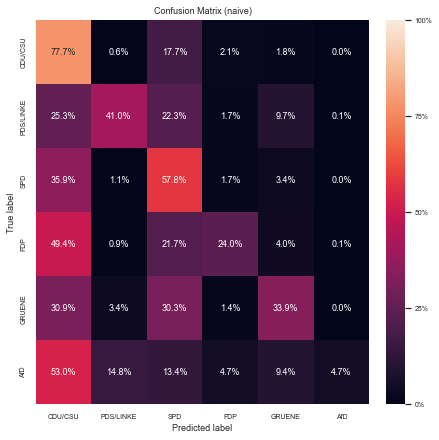

In [118]:
import seaborn as sns

plt.rcParams["text.usetex"] = False

def plot_confusion_matrix(conf_mat, title, filename):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    normalized_cm = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(normalized_cm, annot=True, fmt='.1%', ax=ax, vmin=0, vmax=1)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, 0.5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_xlabel('Predicted label');ax.set_ylabel('True label')
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(parties); ax.yaxis.set_ticklabels(parties)
    fig.savefig(filename)

plot_confusion_matrix(conf_mat, 'Confusion Matrix (naive)', "confusion_matrix_naive.pdf")

In [37]:
def get_class_accuracies(conf_mat):
    return conf_mat.diagonal() / conf_mat.sum(axis = 1)

list(zip(parties, get_class_accuracies(conf_mat)))

[('CDU/CSU', 0.7774566473988439),
 ('PDS/LINKE', 0.4099953725127256),
 ('SPD', 0.5782422293676313),
 ('FDP', 0.2402321083172147),
 ('GRUENE', 0.33866575901974133),
 ('AfD', 0.04697986577181208)]

Hand-engineered features only

In [38]:
class TextDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.drop(columns=["text"])
        X = X.to_numpy()

        return X

hand_engineered_regression = Pipeline([
    ('text_dropper', TextDropper()),
    ('scaler', StandardScaler()),
    ('regression', LogisticRegression(solver='liblinear', max_iter=300, random_state=42)),
])

In [39]:
hand_engineered_regression.fit(X_train, y_train)
hand_engineered_regression.score(X_test, y_test)

0.3412146963259185

In [40]:
class BoWOnlyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, num_words, max_df=0.5):
        self.num_words = num_words
        self.max_df = max_df
        
    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(analyzer="word", stop_words=None, tokenizer=None, preprocessor=None, max_features=self.num_words, max_df=self.max_df) # max_df and min_df might be worth checking out later
        self.vectorizer.fit(X["text"])
        return self

    def transform(self, X):
        bow = self.vectorizer.transform(X["text"])
        return bow
    
bow_only_regression = Pipeline([
    ('bow_extractor', BoWOnlyExtractor(num_words=15000)),
    ('scaler', StandardScaler(with_mean=False)),
    ('regression', LogisticRegression(solver='saga', random_state=42, n_jobs=-1, max_iter=250)),
])

In [41]:
bow_only_regression.fit(X_train, y_train)
bow_only_regression.score(X_test, y_test)

/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.5378155461134716

# Class-weighted Logistic Regression

In [42]:
from sklearn.metrics import accuracy_score

bow_regression_fair = Pipeline([
    ('bow_extractor', BoWExtractor(num_words=15000)),
    ('scaler', StandardScaler(with_mean=False)),
    ('regression', LogisticRegression(solver='saga', random_state=42, n_jobs=-1, max_iter=250, class_weight="balanced")),
])

bow_regression_fair.fit(X_train, y_train)
y_test_pred_fair = bow_regression_fair.predict(X_test)
accuracy_score(y_test, y_test_pred_fair)

/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.5019745063734067

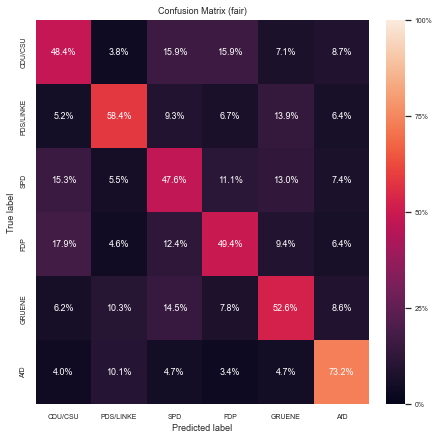

In [119]:
conf_mat_fair = confusion_matrix(y_test, y_test_pred_fair, labels=parties)
plot_confusion_matrix(conf_mat_fair, 'Confusion Matrix (fair)', 'confusion_matrix_fair.pdf')

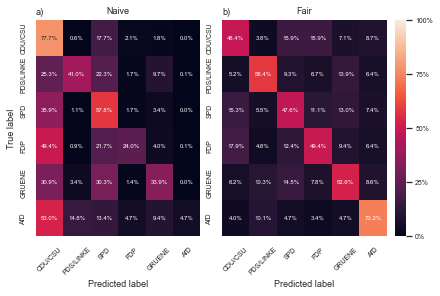

In [150]:
from tueplots import figsizes

def plot_confusion_matrix_side_by_side(conf_mat_A, conf_mat_B, title_A, title_B, filename):
    plt.rcParams.update(figsizes.neurips2021(ncols=2))
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    annots = ["a)", "b)"]
    for (i, (conf_mat, title)) in enumerate(zip([conf_mat_A, conf_mat_B], [title_A, title_B])):
        normalized_cm = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]
        ax = axs[i]
        use_cbar = (i == 1)
        ax = sns.heatmap(normalized_cm, annot=True, fmt='.1%', ax=ax, vmin=0, vmax=1, cbar=use_cbar, annot_kws={"size": 6})
        ax.text(0, -0.15, annots[i])
        if use_cbar:
            cbar = ax.collections[0].colorbar
            cbar.set_ticks([0, .25, 0.5, .75, 1])
            cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
        ax.set_xlabel('Predicted label')
        if i == 0:
            ax.set_ylabel('True label')
        ax.set_title(title); 
        ax.xaxis.set_ticklabels(parties, rotation=45); ax.yaxis.set_ticklabels(parties)
    fig.savefig(filename)
    
plot_confusion_matrix_side_by_side(conf_mat, conf_mat_fair, 'Naive', 'Fair', 'confusion_matrix_naive_vs_fair.pdf')

In [44]:
list(zip(parties, get_class_accuracies(conf_mat_fair)))

[('CDU/CSU', 0.4841801034377852),
 ('PDS/LINKE', 0.5844516427579824),
 ('SPD', 0.47642015005359056),
 ('FDP', 0.49361702127659574),
 ('GRUENE', 0.5255275697753574),
 ('AfD', 0.7315436241610739)]

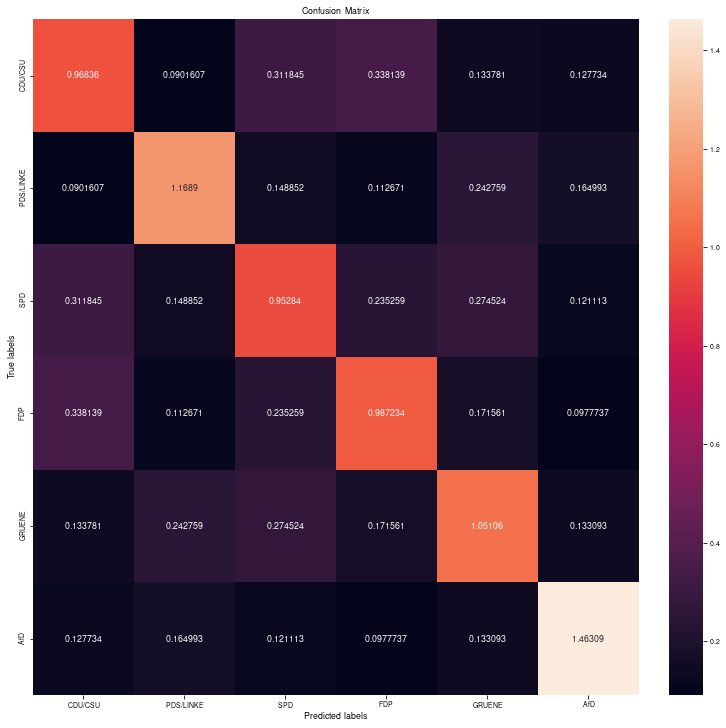

In [45]:
def get_similarities(conf_mat):
    normalized_cm = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]
    return normalized_cm.T + normalized_cm

sim_matrix_fair = get_similarities(conf_mat_fair)
plot_confusion_matrix(sim_matrix_fair)

# With PCA

In [152]:
from sklearn.decomposition import TruncatedSVD

fair_regression_svd = Pipeline([
    ('bow_extractor', BoWExtractor(num_words=15000)),
    ('decomposer', TruncatedSVD()),
    ('scaler', StandardScaler(with_mean=False)),
    ('regression', LogisticRegression(solver='saga', random_state=42, n_jobs=-1, max_iter=250, class_weight="balanced")),
], verbose=True)

param_grid_svd = [
    {'decomposer__n_components': [10, 100, 1000]}
]

grid_search_svd = GridSearchCV(fair_regression_svd, param_grid_svd, cv=3, scoring='accuracy', verbose=4, error_score="raise")
grid_search_svd.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  38.3s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total=   3.9s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ........ (step 4 of 4) Processing regression, total=  23.6s
[CV 1/3] END .......decomposer__n_components=10;, score=0.172 total time= 1.3min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  36.9s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total=   3.9s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ........ (step 4 of 4) Processing regression, total=  22.4s
[CV 2/3] END .......decomposer__n_components=10;, score=0.177 total time= 1.2min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  37.2s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total=   3.9s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing regression, total=  20.0s
[CV 3/3] END .......decomposer__n_components=10;, score=0.189 total time= 1.2min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  38.8s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total=  27.1s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ........ (step 4 of 4) Processing regression, total= 1.5min
[CV 1/3] END ......decomposer__n_components=100;, score=0.301 total time= 2.8min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  37.2s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total=  28.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ........ (step 4 of 4) Processing regression, total= 1.6min
[CV 2/3] END ......decomposer__n_components=100;, score=0.301 total time= 2.8min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  41.2s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total=  26.6s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ........ (step 4 of 4) Processing regression, total= 1.5min
[CV 3/3] END ......decomposer__n_components=100;, score=0.306 total time= 2.8min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  35.8s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total= 3.5min
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.9s


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ........ (step 4 of 4) Processing regression, total=12.1min
[CV 1/3] END .....decomposer__n_components=1000;, score=0.422 total time=16.5min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  35.4s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total= 3.5min
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.9s


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ........ (step 4 of 4) Processing regression, total=12.1min
[CV 2/3] END .....decomposer__n_components=1000;, score=0.424 total time=16.4min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  35.5s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total= 3.4min
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.9s


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ........ (step 4 of 4) Processing regression, total=12.1min
[CV 3/3] END .....decomposer__n_components=1000;, score=0.424 total time=16.4min
[Pipeline] ..... (step 1 of 4) Processing bow_extractor, total=  51.5s
[Pipeline] ........ (step 2 of 4) Processing decomposer, total= 5.0min
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.3s
[Pipeline] ........ (step 4 of 4) Processing regression, total=18.1min


/home/chelmney/miniconda3/envs/bundestag_party_prediction/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('bow_extractor',
                                        BoWExtractor(num_words=15000)),
                                       ('decomposer', TruncatedSVD()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('regression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=250,
                                                           n_jobs=-1,
                                                           random_state=42,
                                                           solver='saga'))],
                                verbose=True),
             param_grid=[{'decomposer__n_components': [10, 100, 1000]}],
             scoring='accuracy', verbose=4)

In [153]:
grid_search_svd.best_estimator_

Pipeline(steps=[('bow_extractor', BoWExtractor(num_words=15000)),
                ('decomposer', TruncatedSVD(n_components=1000)),
                ('scaler', StandardScaler(with_mean=False)),
                ('regression',
                 LogisticRegression(class_weight='balanced', max_iter=250,
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))],
         verbose=True)

In [183]:
with open('../data/raw/manifestos.json') as json_file:
    data_manifestos = json.load(json_file)

for party in data_manifestos:
    data_manifestos[party] = " ".join(data_manifestos[party])
    
party_name_map = {
    'CDU': 'CDU/CSU',
    'LINKE': 'PDS/LINKE',
    'SPD': 'SPD',
    'FDP': 'FDP',
    'GRUENE': 'GRUENE',
    'AFD': 'AfD'
}

data_manifestos = {party_name_map[party]: text for (party, text) in data_manifestos.items()}
manifesto_parties = data_manifestos.keys()
chairs = []
texts = []
for party in manifesto_parties:
    texts.append(data_manifestos[party])
    chairs.append(False)
    
manifesto_df_dict = {'party': manifesto_parties, 'chair': chairs, 'text': texts}
manifesto_df = pd.DataFrame(manifesto_df_dict)
manifesto_df.to_csv('../data/raw/manifestos.csv', index=False)
manifesto_df

,party,chair,text
0,CDU/CSU,False,das programm für stabilität und erneuerung gem...
1,SPD,False,unser zukunftsprogramm das zukunftsprogramm de...
2,FDP,False,nie gab es mehr zu tun wahlprogramm der wir si...
3,GRUENE,False,deutschland alles ist drin bundestagswahlprogr...
4,PDS/LINKE,False,zeit zu handeln für soziale sicherheit frieden...
5,AfD,False,programm der alternative für deutschland für d...


In [185]:
manifesto_df = pd.read_csv('../data/raw/manifestos.csv')
manifesto_df

,party,chair,text
0,CDU/CSU,False,das programm für stabilität und erneuerung gem...
1,SPD,False,unser zukunftsprogramm das zukunftsprogramm de...
2,FDP,False,nie gab es mehr zu tun wahlprogramm der wir si...
3,GRUENE,False,deutschland alles ist drin bundestagswahlprogr...
4,PDS/LINKE,False,zeit zu handeln für soziale sicherheit frieden...
5,AfD,False,programm der alternative für deutschland für d...


In [194]:
from sklearn.pipeline import Pipeline
from src.data.transformers.clean_text import *
from src.data.transformers.extract_features import *


cleaning_pipe = Pipeline(
        [
            ("chair_remover", RemoveChairTransformer()),
            ("independent_party_remover", RemoveIndependentPartyTransformer()),
            (
                "commentary_remover",
                RemoveCommentaryTransformer(remove_leftovers=True, verbose=True),
            ),
            ("special_chars_remover", RemoveSpecialCharacterTransformer()),
            ("spelling_reformer", GermanSpellingReformTransformer()),
            ("double_fullstops_remover", ReplaceDoubleFullstopsTransformer()),
        ],
        verbose=True,
    )


manifesto_data = cleaning_pipe.fit_transform(manifesto_df)
manifesto_data.to_csv('../data/processed/manifestos_clean.csv')

feature_pipe = Pipeline(
        [
            ("text_length_extractor", TextLengthExtractor()),
            ("avg_sentence_length_extractor", AvgSentenceLengthExtractor()),
            ("num_exclamation_question_extractor", NumExclamationQuestionExtractor()),
            ("readability_extractor", ReadabilityExtractor()),
            ("tokenizer", Tokenizer()),
            ("num_profanities_extractor", NumOfProfanitiesExtractor()),
            ("ttr_extractor", TTRExtractor()),
            ("sentiment_extractor", SentimentExtractor()),
            ("avg_word_length_extractor", AvgWordLengthExtractor()),
            ("stop_word_fraction_extractor", StopWordFractionExtractor()),
            ("stop_word_remover", StopWordRemover()),
            ("tfidf_score_extractor", TfidfScoreExtractor()),
        ],
        verbose=True,
    )

manifesto_data = feature_pipe.fit_transform(manifesto_data)

[Pipeline] ..... (step 1 of 6) Processing chair_remover, total=   0.0s
[Pipeline]  (step 2 of 6) Processing independent_party_remover, total=   0.0s
[Pipeline]  (step 3 of 6) Processing commentary_remover, total=   0.0s
[Pipeline]  (step 4 of 6) Processing special_chars_remover, total=   0.0s
[Pipeline] . (step 5 of 6) Processing spelling_reformer, total=   0.0s
[Pipeline]  (step 6 of 6) Processing double_fullstops_remover, total=   0.0s
[Pipeline]  (step 1 of 12) Processing text_length_extractor, total=   0.0s
[Pipeline]  (step 2 of 12) Processing avg_sentence_length_extractor, total=   0.0s
[Pipeline]  (step 3 of 12) Processing num_exclamation_question_extractor, total=   0.0s
[Pipeline]  (step 4 of 12) Processing readability_extractor, total=   0.6s
[Pipeline] ........ (step 5 of 12) Processing tokenizer, total=   1.2s
[Pipeline]  (step 6 of 12) Processing num_profanities_extractor, total=   0.7s
[Pipeline] .... (step 7 of 12) Processing ttr_extractor, total=   0.0s
[Pipeline]  (ste

In [195]:
manifesto_data

,index,party,chair,text,text_length,avg_sentence_length,relative_num_exclamations,relative_num_questions,readability,num_profanities,TTR,sentiment,avg_word_length,stop_word_fraction,avg_tfidf
0,0,CDU/CSU,False,programm stabilität erneuerung gemeinsam moder...,326762,326762.0,0.0,0.0,-42938.71,0,0.191626,0.044429,6.600907,0.465294,0.001524
1,1,SPD,False,zukunftsprogramm zukunftsprogramm spd wofür st...,179304,179304.0,0.0,0.0,-23740.71,0,0.232347,0.037783,6.536357,0.465198,0.001340
2,2,FDP,False,nie gab mehr tun wahlprogramm freie demokraten...,287612,287612.0,0.0,0.0,-37373.71,3,0.215738,0.021774,6.685050,0.431743,0.000821
3,3,GRUENE,False,deutschland drin bundestagswahlprogramm bereit...,533299,533299.0,0.0,0.0,-71289.71,0,0.164239,0.027298,6.475365,0.435612,0.001142
4,4,PDS/LINKE,False,zeit handeln soziale sicherheit frieden klimag...,531018,531018.0,0.0,0.0,-71710.86,0,0.168710,-0.011497,6.399105,0.431780,0.001595
5,5,AfD,False,programm alternative deutschland wahl deutsche...,211393,211393.0,0.0,0.0,-26887.56,1,0.250139,-0.024452,6.848884,0.431330,0.001212


In [196]:
cols_to_replace = ["text_length", "avg_sentence_length", "relative_num_exclamations", "relative_num_questions", "readability"]
for col in cols_to_replace:
    manifesto_data[col] = feats[col].mean()
manifesto_data

,index,party,chair,text,text_length,avg_sentence_length,relative_num_exclamations,relative_num_questions,readability,num_profanities,TTR,sentiment,avg_word_length,stop_word_fraction,avg_tfidf
0,0,CDU/CSU,False,programm stabilität erneuerung gemeinsam moder...,2979.941222,121.763512,0.000413,0.000866,41.372986,0,0.191626,0.044429,6.600907,0.465294,0.001524
1,1,SPD,False,zukunftsprogramm zukunftsprogramm spd wofür st...,2979.941222,121.763512,0.000413,0.000866,41.372986,0,0.232347,0.037783,6.536357,0.465198,0.001340
2,2,FDP,False,nie gab mehr tun wahlprogramm freie demokraten...,2979.941222,121.763512,0.000413,0.000866,41.372986,3,0.215738,0.021774,6.685050,0.431743,0.000821
3,3,GRUENE,False,deutschland drin bundestagswahlprogramm bereit...,2979.941222,121.763512,0.000413,0.000866,41.372986,0,0.164239,0.027298,6.475365,0.435612,0.001142
4,4,PDS/LINKE,False,zeit handeln soziale sicherheit frieden klimag...,2979.941222,121.763512,0.000413,0.000866,41.372986,0,0.168710,-0.011497,6.399105,0.431780,0.001595
5,5,AfD,False,programm alternative deutschland wahl deutsche...,2979.941222,121.763512,0.000413,0.000866,41.372986,1,0.250139,-0.024452,6.848884,0.431330,0.001212


In [201]:
X_manifesto = manifesto_data.drop(columns=["index", "chair"])
y_manifesto = X_manifesto['party']
X_manifesto = X_manifesto.drop(columns=['party'])
X_manifesto.reset_index(drop=True, inplace=True)
    
y_manifesto_preds = bow_regression_fair.predict(X_manifesto)
for (i, (truth, pred)) in enumerate(zip(y_manifesto, y_manifesto_preds)):
    print(f"Truth: {truth}, predicted: {pred}")
print(f"Accuracy: {accuracy_score(y_manifesto_preds, y_manifesto)}")

Truth: CDU/CSU, predicted: CDU/CSU
Truth: SPD, predicted: SPD
Truth: FDP, predicted: FDP
Truth: GRUENE, predicted: GRUENE
Truth: PDS/LINKE, predicted: PDS/LINKE
Truth: AfD, predicted: AfD
Accuracy: 1.0


# Latent Dirichlet Allocation

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, max_iter=5)
lda.fit(bow)

In [ ]:
lda_feats = lda.transform(bow)

In [ ]:
lda_df = pd.DataFrame(lda_feats)
lda_df = lda_df.add_prefix('lda_')
lda_df.head()